# Linear Regression

The purpose of regression is comparison. We start with some population of subjects that has a variety of attributes, and we want to understand how some measure varies with those attributes. For example, do men and woman tip differently? If we allow the dependent variable $y$ to take on the value of a tip, and allow $X$ to take on the value of gender (which we are keeping binary for ease of exposition), we can reformulate the comparison in the following way:

$$E[y_{\text{tip}} | X_m] - E[y_{\text{tip}} | X_f]$$

In other words, what is the difference in expected tip for males and females? We often, for theoretical reasons, interpret this in a slightly different, but not exactly equivalent way.

$$\frac{\partial y}{\partial x}$$

That is, how does the expected tip change as we change the value of gender. We are not proposing to look within person to see this change in gender value, but rather across people. Hence, the framing as comparison. We are comparing to subgroups, men and women, and using the comparison to speak to the variation explained by a change in the gender attribute value.

In this notebook, we seek to cement the idea of regression by making the comparisons explicit. With categorical data, the exposition is fairly straightforward. With continuous data, there are some differences, but the overall framing still works. We will use `seaborn`'s [tips dataset](https://www.kaggle.com/ranjeetjain3/seaborn-tips-dataset).

In [27]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sb
from statsconcepts.viz import Viz, SeriesPlotIn
from typing import List, Dict
from sympy

colors: List[str] = sb.color_palette("Set1")

%load_ext autoreload
%aimport statsconcepts.viz
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Input Data

The "tips" dataset can be loaded directly from the `seaborn` package.

In [21]:
df: pd.DataFrame = sb.load_dataset("tips")
df.index.name = "transaction"
data: xr.Dataset = xr.Dataset(df)
    
data["ltip"] = np.log(data["tip"])
data["ltotal"] = np.log(data["total_bill"])
    
data

<xarray.Dataset>
Dimensions:      (transaction: 244)
Coordinates:
  * transaction  (transaction) int64 0 1 2 3 4 5 6 ... 238 239 240 241 242 243
Data variables:
    total_bill   (transaction) float64 16.99 10.34 21.01 ... 22.67 17.82 18.78
    tip          (transaction) float64 1.01 1.66 3.5 3.31 ... 2.0 2.0 1.75 3.0
    sex          (transaction) object 'Female' 'Male' 'Male' ... 'Male' 'Female'
    smoker       (transaction) object 'No' 'No' 'No' 'No' ... 'Yes' 'No' 'No'
    day          (transaction) object 'Sun' 'Sun' 'Sun' ... 'Sat' 'Sat' 'Thur'
    time         (transaction) object 'Dinner' 'Dinner' ... 'Dinner' 'Dinner'
    size         (transaction) int64 2 3 3 2 4 4 2 4 2 2 ... 2 2 2 2 3 3 2 2 2 2
    ltip         (transaction) float64 0.00995 0.5068 1.253 ... 0.5596 1.099
    ltotal       (transaction) float64 2.833 2.336 3.045 ... 3.121 2.88 2.933

## What is the distribution of tips? 

tip mean: 3.00
ltip mean: 1.00


<AxesSubplot:title={'center':'Distribution of Tips Before (Red) and After (Blue) Log Transformation'}, xlabel='tip', ylabel='Count'>

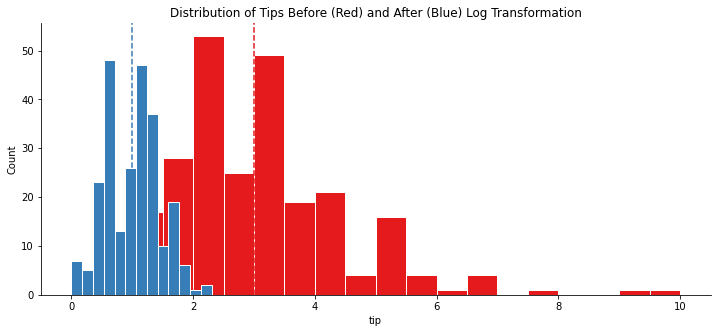

In [32]:
dollar_series: Dict[str, SeriesPlotIn] = {
    col: SeriesPlotIn(col, data[col], colors[i]) for i, col in enumerate(["tip", "ltip", "total_bill", "ltotal"])
}
    
Viz.univariate_compare(
    series=[dollar_series[col] for col in ["tip", "ltip"]],
    stat=np.mean,
    title="Distribution of Tips Before (Red) and After (Blue) Log Transformation",
    alpha=0.2
)

## What is the distribution of the total bill?

total_bill mean: 19.79
ltotal mean: 2.89


<AxesSubplot:title={'center':'Distribution of Total Bill Before (Green) and After (Purple) Log Transformation'}, xlabel='total_bill', ylabel='Count'>

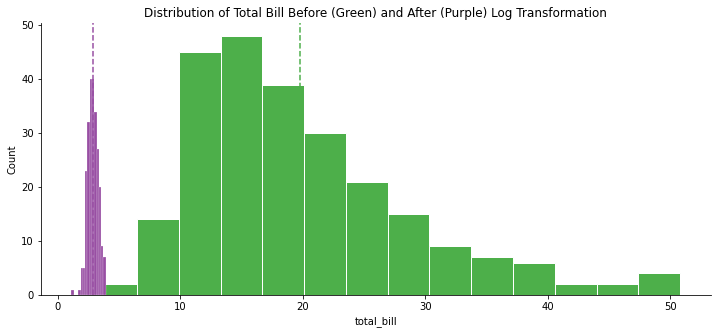

In [34]:
Viz.univariate_compare(
    series=[dollar_series[col] for col in ["total_bill", "ltotal"]],
    stat=np.mean,
    title="Distribution of Total Bill Before (Green) and After (Purple) Log Transformation",
    alpha=0.2
)

tip mean: 3.09
tip mean: 2.83


<AxesSubplot:title={'center':'Distribution of Tips For Men (Green) and Women (Purple)'}, xlabel='tip', ylabel='Count'>

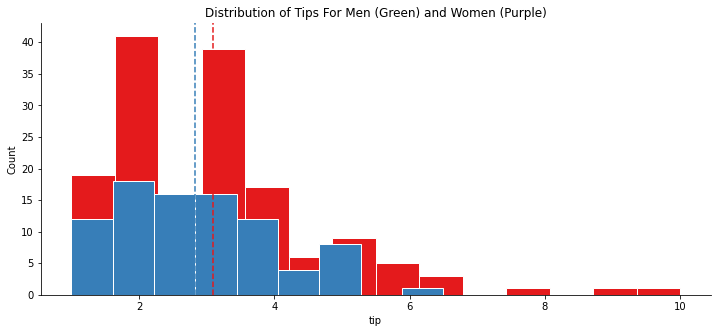

In [42]:
gender_tips: Dict[str, SeriesPlotIn] = {
    s: SeriesPlotIn("tip", data["tip"].where(data["sex"]==s), colors[i]) 
    for i, s in enumerate(["Male", "Female"])
}
    
Viz.univariate_compare(
    series=[gender_tips[s] for s in gender_tips.keys()],
    stat=np.mean,
    title="Distribution of Tips For Men (Green) and Women (Purple)",
    alpha=0.2
)

In [130]:
np.mean.__name__

'mean'

In [107]:
data

<xarray.Dataset>
Dimensions:      (transaction: 244)
Coordinates:
  * transaction  (transaction) int64 0 1 2 3 4 5 6 ... 238 239 240 241 242 243
Data variables:
    total_bill   (transaction) float64 16.99 10.34 21.01 ... 22.67 17.82 18.78
    tip          (transaction) float64 1.01 1.66 3.5 3.31 ... 2.0 2.0 1.75 3.0
    sex          (transaction) object 'Female' 'Male' 'Male' ... 'Male' 'Female'
    smoker       (transaction) object 'No' 'No' 'No' 'No' ... 'Yes' 'No' 'No'
    day          (transaction) object 'Sun' 'Sun' 'Sun' ... 'Sat' 'Sat' 'Thur'
    time         (transaction) object 'Dinner' 'Dinner' ... 'Dinner' 'Dinner'
    size         (transaction) int64 2 3 3 2 4 4 2 4 2 2 ... 2 2 2 2 3 3 2 2 2 2

In [65]:
from sympy import symbols, MatrixSymbol
from sympy.matrices import Matrix
from typing import List
import numpy as np

a, b, d, g = symbols(r"\alpha, \beta, \delta, \gamma")

ab: Matrix = Matrix([[a], [b]])
dg: Matrix = Matrix([[d], [g]])
A: MatrixSymbol = MatrixSymbol(r"\Lambda", 2, 2)

In [36]:
ab

Matrix([
[\alpha],
[ \beta]])

In [37]:
dg

Matrix([
[\delta],
[\gamma]])

In [38]:
ab - dg

Matrix([
[\alpha - \delta],
[ \beta - \gamma]])

In [39]:
ab.T * dg

Matrix([[\alpha*\delta + \beta*\gamma]])

In [40]:
A * ab

\Lambda*Matrix([
[\alpha],
[ \beta]])

In [59]:
class IndexedMatrix:
    
    def __init__(self, base: Symbol, nrows: int, ncols: int) -> None:
        self.base: Symbol = base
        self.nrows: int = nrows
        self.ncols: int = ncols
            
    @staticmethod
    def indexed_symbols(base: Symbol, nrows: int, ncols: int) -> List[Symbol]:
        m: Matrix = Matrix([
            [Symbol(str(base) + "_" + str(i) + "," + str(j)) for j in range(ncols)] 
            for i in range(nrows)
        ])
        return m

In [61]:
huh = IndexedMatrix.indexed_symbols(a, 5, 4)

huh

Matrix([
[\alpha_0,0, \alpha_0,1, \alpha_0,2, \alpha_0,3],
[\alpha_1,0, \alpha_1,1, \alpha_1,2, \alpha_1,3],
[\alpha_2,0, \alpha_2,1, \alpha_2,2, \alpha_2,3],
[\alpha_3,0, \alpha_3,1, \alpha_3,2, \alpha_3,3],
[\alpha_4,0, \alpha_4,1, \alpha_4,2, \alpha_4,3]])

In [64]:
huh.T * huh

Matrix([
[                                        \alpha_0,0**2 + \alpha_1,0**2 + \alpha_2,0**2 + \alpha_3,0**2 + \alpha_4,0**2, \alpha_0,0*\alpha_0,1 + \alpha_1,0*\alpha_1,1 + \alpha_2,0*\alpha_2,1 + \alpha_3,0*\alpha_3,1 + \alpha_4,0*\alpha_4,1, \alpha_0,0*\alpha_0,2 + \alpha_1,0*\alpha_1,2 + \alpha_2,0*\alpha_2,2 + \alpha_3,0*\alpha_3,2 + \alpha_4,0*\alpha_4,2, \alpha_0,0*\alpha_0,3 + \alpha_1,0*\alpha_1,3 + \alpha_2,0*\alpha_2,3 + \alpha_3,0*\alpha_3,3 + \alpha_4,0*\alpha_4,3],
[\alpha_0,0*\alpha_0,1 + \alpha_1,0*\alpha_1,1 + \alpha_2,0*\alpha_2,1 + \alpha_3,0*\alpha_3,1 + \alpha_4,0*\alpha_4,1,                                         \alpha_0,1**2 + \alpha_1,1**2 + \alpha_2,1**2 + \alpha_3,1**2 + \alpha_4,1**2, \alpha_0,1*\alpha_0,2 + \alpha_1,1*\alpha_1,2 + \alpha_2,1*\alpha_2,2 + \alpha_3,1*\alpha_3,2 + \alpha_4,1*\alpha_4,2, \alpha_0,1*\alpha_0,3 + \alpha_1,1*\alpha_1,3 + \alpha_2,1*\alpha_2,3 + \alpha_3,1*\alpha_3,3 + \alpha_4,1*\alpha_4,3],
[\alpha_0,0*\alpha_0,2 + \alpha_1,0

In [68]:
Matrix(np.)

Matrix([
[  -1.00962052784828,    1.67438457138504,  -1.07623950065805,  -2.3028076723383, -1.07634749999558],
[  0.813413347261627,  -0.874749193918841,  0.488944346256053, 0.419907927766864, -0.33693010241362],
[   0.65744585530597, -0.0925185083110535, -0.900170442468159, 0.264390186770396, 0.497947044065967],
[-0.0430254767059568,  -0.277694322627464, 0.0158359304855636, 0.352711027082456, 0.350320175176735]])

In [78]:
test_shape = (2, 3, 4)
A = np.full(test_shape, a)
A

array([[[\alpha, \alpha, \alpha, \alpha],
        [\alpha, \alpha, \alpha, \alpha],
        [\alpha, \alpha, \alpha, \alpha]],

       [[\alpha, \alpha, \alpha, \alpha],
        [\alpha, \alpha, \alpha, \alpha],
        [\alpha, \alpha, \alpha, \alpha]]], dtype=object)

In [81]:
dim_extents = dict(enumerate(test_shape))
dim_extents

{0: 2, 1: 3, 2: 4}

In [84]:
np.vectorize(lambda s: Symbol(str(s) + "_0"))(A[0, :, :])

array([[\alpha_0, \alpha_0, \alpha_0, \alpha_0],
       [\alpha_0, \alpha_0, \alpha_0, \alpha_0],
       [\alpha_0, \alpha_0, \alpha_0, \alpha_0]], dtype=object)